# Visualization of product flow

*Paul Bayer, 2017-09-21, v0.2*

This notebook demonstrates the use of graphs  and charts in `PFlow` in order to visualize product flow. We use the following libraries:

In [1]:
using LightGraphs, GraphPlot, DataFrames
using PFlow

## Order flow

In `PFlow` we define orders in simple `.csv`-files, eg.: 

In [2]:
orderfile = "../../models/MOD01_orders.csv"
tab = readtable(orderfile)

,order,job,workunits,plan_time,batch_size,target
1,ORD01,JOB01,MC01,5.0,1,NA
2,ORD01,JOB02,"MC02,MC03,MC04",8.0,1,NA
3,ORD01,JOB03,MC05,4.0,1,NA
4,ORD02,JOB01,MC01,4.0,1,NA
5,ORD02,JOB02,"MC03,MC02",7.0,1,NA
6,ORD02,JOB03,MC04,3.0,1,NA
7,ORD02,JOB04,MC05,4.5,1,NA


The `.csv` file contains two orders: `ORD01` and `ORD02`. From it `PFlow` constructs a dictionary containing the jobs of each order: 

In [3]:
d = readOrders(orderfile)

Dict{String,Array{PFlow.Job,1}} with 2 entries:
  "ORD02" => PFlow.Job[PFlow.Job(0, "JOB01", String["MC01"], 4.0, 0.0, 0.0, 0, …
  "ORD01" => PFlow.Job[PFlow.Job(0, "JOB01", String["MC01"], 5.0, 0.0, 0.0, 0, …

If orders are defined, they establish a flow through a production system. Using the above order dictionary we can display the order graph, showing the possible flow paths of orders through the production system. Order 1 (`ORD01`) establishes the following flow:

HTML{String}("<h3>Order graph for ORD01</h3>")

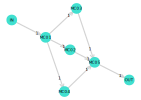

In [4]:
srand(2017) # for reproducibility
(G, nodes, weights) = ordergraph(d, "ORD01")
display(HTML("<h3>Order graph for ORD01</h3>"))
display(gplot(G, nodelabel=nodes, edgelabel=weights, edgelinewidth=weights))

… or for `ORD02`:

HTML{String}("<h3>Order graph for ORD02</h3>")

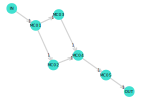

In [5]:
srand(2017) # for reproducibility
(G, nodes, weights) = ordergraph(d, "ORD02")
display(HTML("<h3>Order graph for ORD02</h3>"))
display(gplot(G, nodelabel=nodes, edgelabel=weights, edgelinewidth=weights))

If we don't select for an order, we get a combined order graph, showing the flow paths of multiple orders through the system.

HTML{String}("<h3>Combined order graph</h3>")

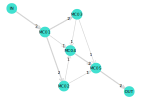

In [6]:
srand(2017) # for reproducibility
(G, nodes, weights) = ordergraph(d)
display(HTML("<h3>Combined order graph</h3>"))
display(gplot(G, nodelabel=nodes, edgelabel=weights, edgelinewidth=weights))

Now the edges have different weights, showing how many orders use that edge.

## Product flow

How many products pass over each edge and what this means for the workload of the work units involved, depends on many factors such as

- number of products scheduled for each order,
- scheduling strategy (batch or leveled),
- processing times,
- characteristics of the work units (variation in processing times and failures),
- chance.

Therefore it has to be established by simulation. We schedule 7 products of `ORD01` and 18 of `ORD02` and create a leveled master production schedule: 

In [7]:
plan1 = Planned(123,  7, 123000, "Order 1", "Order 1 description", "ORD01")
plan2 = Planned(456, 18, 456000, "Order 2", "Order 2 description", "ORD02")
mps = create_mps([plan1, plan2], d);
println("master production schedule of $(length(mps)) products")

master production schedule of 25 products


Then we read in the work units, which are defined in a `.csv` file:

In [8]:
wufile = "../../models/MOD01_workunits.csv"
tab = readtable(wufile)

,name,description,kind,input,jobs,output,alpha,mtbf,mttr,timeslice,multitasking
1,MC01,machining centre,1,1,1,1,100,500,10,0,0
2,MC02,machining centre,1,1,1,1,100,500,10,0,0
3,MC03,machining centre,1,1,1,1,100,500,10,0,0
4,MC04,machining centre,1,1,1,1,100,500,10,0,0
5,MC05,machining centre,1,1,1,1,100,500,10,0,0


Those are 5 machines (`kind = 1`) which each one `input`, `job` and `output` buffer, a slight variation (`alpha = 100`) in processing times, meantime between failures (`mtbf`) of 500 and meantime to repair (`mttr`) of 10. Timeslice for multitasking is not used.

If we read this file into `PFlow`, it creates from it five work unit processes waiting for work. Therefore we have to create our simulation variable `sim` first. 

In [9]:
srand(2345)  # seed random number generator for reproducibility
sim = DES()
wus = readWorkunits(wufile, sim);

Then we have to 
1. define a warehouse variable for finished products, 
2. start the scheduling on the simulation variable `sim`, the workunits `wus`, the master production schedule `mps` and the `finished` warehouse, and
3. run the simulation for 150 minutes.

In [10]:
finished = Products()
sleep(1) # wait for sync

start_scheduling(sim, wus, mps, finished)
simulate(sim, 140);
println("$(length(finished)) products were produced")

Simulation ends after 173 ms - next event at:140.0 ≥ stime after 717 events
25 products were produced


We can look at the workload of the machines over time:

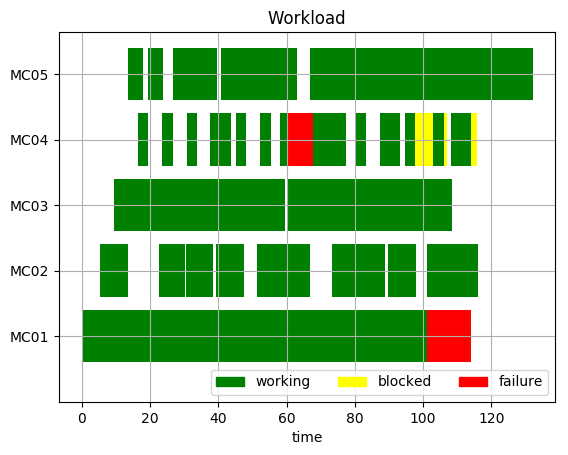

In [11]:
loadtime(wus)

or at a bar chart:

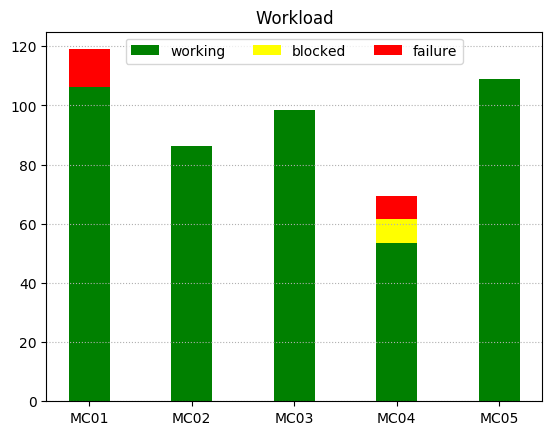

In [12]:
loadbars(wus)

This shows, that `MC04` and `MC02` were underused and `MC01` or `MC05` seem to be bottlenecks. A flow diagram shows the cause of it:

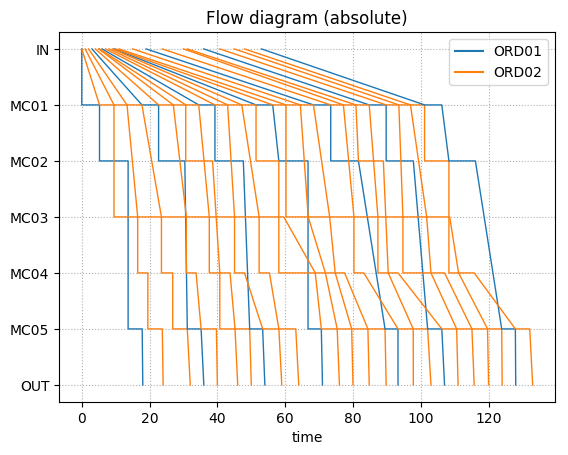

In [13]:
flow(finished, wus)

`MC01` and `MC05` were nearly working continuously. `MC02` and `MC04` were not working continuously and products took different paths through the system.

HTML{String}("<h3>Product flow graph</h3>")

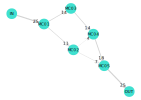

In [14]:
srand(2017) # for reproducibility
(G, nodes, weights) = flowgraph(finished)
display(HTML("<h3>Product flow graph</h3>"))
display(gplot(G, nodelabel=nodes, edgelabel=weights, edgelinewidth=weights))

As we could guess from the order graphs above, `MC01` and `MC05` are system constraints as they have no compensating work units.

In [15]:
res = leadtimetable(finished)
res[:starttime] = round.(res[:starttime], 2)
res[:endtime] = round.(res[:endtime], 2)
res[:leadtime] = round.(res[:leadtime], 2)
tail(res)

,item,code,name,order,starttime,endtime,leadtime
1,456014,456,Order 2,ORD02,30.0,111.0,81.0
2,456015,456,Order 2,ORD02,31.13,115.74,84.61
3,456016,456,Order 2,ORD02,40.71,120.0,79.29
4,456018,456,Order 2,ORD02,48.0,124.0,76.0
5,123007,123,Order 1,ORD01,53.0,128.0,75.0
6,456017,456,Order 2,ORD02,45.0,133.0,88.0


In [16]:
ml = round(mean(res[:leadtime][end-10:end]), 2)
println("mean leadtime for last 10 products: $ml")

mean leadtime for last 10 products: 79.09


## Optimization

Let's use our most underused workunit `MC04` to relieve `MC05` by redefining jobs 2 and 3 in `ORD01`:

In [17]:
orderfile = "../../models/MOD01a_orders.csv"
tab = readtable(orderfile)

,order,job,workunits,plan_time,batch_size,target
1,ORD01,JOB01,MC01,5.0,1,NA
2,ORD01,JOB02,"MC02,MC03",8.0,1,NA
3,ORD01,JOB03,MC04,4.0,1,NA
4,ORD02,JOB01,MC01,4.0,1,NA
5,ORD02,JOB02,"MC03,MC02",7.0,1,NA
6,ORD02,JOB03,MC04,3.0,1,NA
7,ORD02,JOB04,MC05,4.5,1,NA


Our order graph now gets:

HTML{String}("<h3>Combined order graph</h3>")

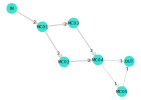

In [18]:
d = readOrders(orderfile)
srand(2017) # for reproducibility
(G, nodes, weights) = ordergraph(d)
display(HTML("<h3>Combined order graph</h3>"))
display(gplot(G, nodelabel=nodes, edgelabel=weights, edgelinewidth=weights))

Then we rerun the simulation and look at the leadtimes:

In [19]:
mps = create_mps([plan1, plan2], d);
srand(2345)  # seed random number generator for reproducibility
sim = DES()
wus = readWorkunits(wufile, sim)
finished = Products()
sleep(1) # wait for sync

start_scheduling(sim, wus, mps, finished)
simulate(sim, 150)
println("$(length(finished)) products were produced")

res = leadtimetable(finished)
res[:starttime] = round.(res[:starttime], 2)
res[:endtime] = round.(res[:endtime], 2)
res[:leadtime] = round.(res[:leadtime], 2)
ml = round(mean(res[:leadtime][end-10:end]), 2)
println("mean leadtime for last 10 products: $ml")

Simulation ends after 5 ms - next event at:150.0 ≥ stime after 727 events
25 products were produced
mean leadtime for last 10 products: 73.16


Our leadtime went down 6 minutes.

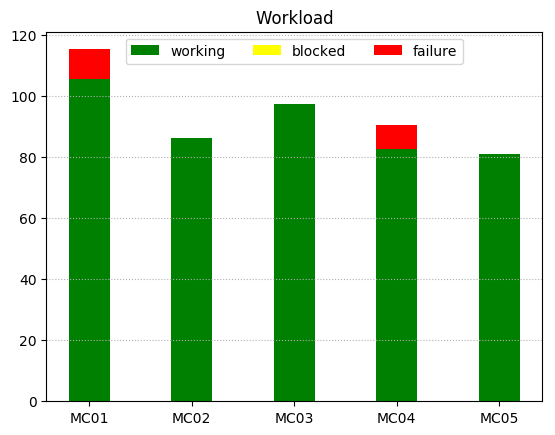

In [20]:
loadbars(wus)

Everything is determined by the now clear bottleneck `MC01`. Therefore we relieve the workload of `MC01` by moving 1 minute of `ORD01-JOB01` to `ORD01-JOB02`: 

In [21]:
orderfile = "../../models/MOD01b_orders.csv"
tab = readtable(orderfile)

,order,job,workunits,plan_time,batch_size,target
1,ORD01,JOB01,MC01,4.0,1,NA
2,ORD01,JOB02,"MC02,MC03",9.0,1,NA
3,ORD01,JOB03,MC04,4.0,1,NA
4,ORD02,JOB01,MC01,4.0,1,NA
5,ORD02,JOB02,"MC03,MC02",7.0,1,NA
6,ORD02,JOB03,MC04,3.0,1,NA
7,ORD02,JOB04,MC05,4.5,1,NA


When we rerun the simulation, our leadtime should further improve.

In [22]:
d = readOrders(orderfile)
mps = create_mps([plan1, plan2], d);
srand(2345)  # seed random number generator for reproducibility
sim = DES()
wus = readWorkunits(wufile, sim)
finished = Products()
sleep(1) # wait for sync 

start_scheduling(sim, wus, mps, finished)
simulate(sim, 150)
println("$(length(finished)) products were produced")

res = leadtimetable(finished)
res[:starttime] = round.(res[:starttime], 2)
res[:endtime] = round.(res[:endtime], 2)
res[:leadtime] = round.(res[:leadtime], 2)
ml = round(mean(res[:leadtime][end-10:end]), 2)
println("mean leadtime for last 10 products: $ml")

Simulation ends after 5 ms - next event at:150.0 ≥ stime after 724 events
25 products were produced
mean leadtime for last 10 products: 69.2


Nice, we got a further improvement of 4, overall 10 minutes improvement in two optimization steps!

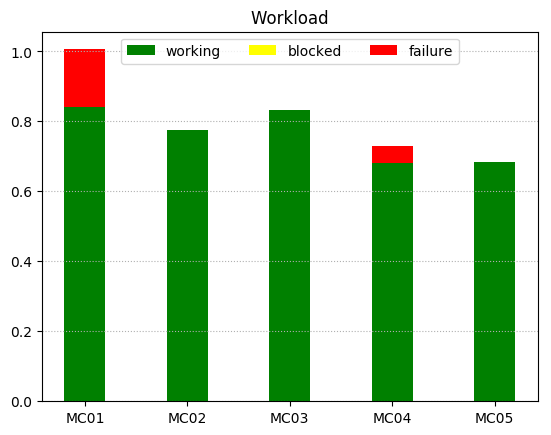

In [23]:
loadbars(wus, 118)

Let's move another 0.5 minutes:

In [24]:
orderfile = "../../models/MOD01c_orders.csv"
tab = readtable(orderfile)

,order,job,workunits,plan_time,batch_size,target
1,ORD01,JOB01,MC01,3.5,1,NA
2,ORD01,JOB02,"MC02,MC03",9.5,1,NA
3,ORD01,JOB03,MC04,4.0,1,NA
4,ORD02,JOB01,MC01,4.0,1,NA
5,ORD02,JOB02,"MC03,MC02",7.0,1,NA
6,ORD02,JOB03,MC04,3.0,1,NA
7,ORD02,JOB04,MC05,4.5,1,NA


In [25]:
d = readOrders(orderfile)
mps = create_mps([plan1, plan2], d);
srand(2345)  # seed random number generator for reproducibility
sim = DES()
wus = readWorkunits(wufile, sim)
finished = Products()
sleep(1)

start_scheduling(sim, wus, mps, finished)
simulate(sim, 150)
println("$(length(finished)) products were produced")

res = leadtimetable(finished)
res[:starttime] = round.(res[:starttime], 2)
res[:endtime] = round.(res[:endtime], 2)
res[:leadtime] = round.(res[:leadtime], 2)
ml = round(mean(res[:leadtime][end-10:end]), 2)
println("mean leadtime for last 10 products: $ml")

Simulation ends after 4 ms - next event at:150.0 ≥ stime after 727 events
25 products were produced
mean leadtime for last 10 products: 70.41


We got no more improvement.

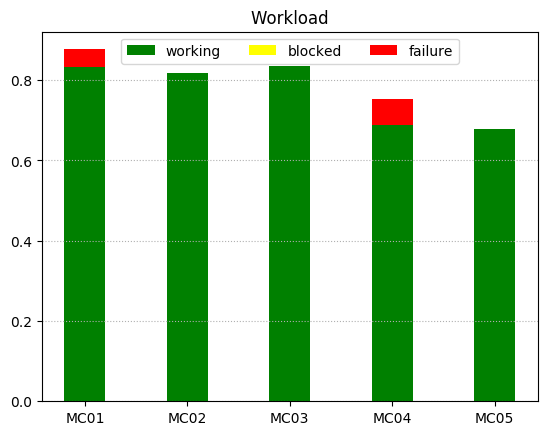

In [26]:
loadbars(wus, 118)

It should be more fruitful, if we could utilize better the capacity of `MC04` and `MC05` ...

HTML{String}("<h3>Product flow graph</h3>")

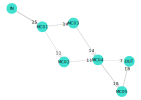

In [27]:
srand(2017) # for reproducibility
(G, nodes, weights) = flowgraph(finished)
display(HTML("<h3>Product flow graph</h3>"))
display(gplot(G, nodelabel=nodes, edgelabel=weights, edgelinewidth=weights))

Clearly, in a real world example, we would use much bigger orders and much longer simulation times to compensate for startup effects, failures and chance. 

Let's increase the demand and the simulation time by an order of magnitude:

In [28]:
plan1 = Planned(123,  70, 123000, "Order 1", "Order 1 description", "ORD01")
plan2 = Planned(456, 180, 456000, "Order 2", "Order 2 description", "ORD02")
mps = create_mps([plan1, plan2], d);
srand(2345)  # seed random number generator for reproducibility
sim = DES()
wus = readWorkunits(wufile, sim)
finished = Products()
sleep(1) # wait for sync

start_scheduling(sim, wus, mps, finished)
simulate(sim, 1500)
println("$(length(finished)) products were produced")


res = leadtimetable(finished)
res[:starttime] = round.(res[:starttime], 2)
res[:endtime] = round.(res[:endtime], 2)
ml = round(mean(res[:leadtime][end-100:end]), 2)
println("mean leadtime for last 100 products: $ml")

Simulation ends after 76 ms - next event at:1500.0 ≥ stime after 7183 events
250 products were produced
mean leadtime for last 100 products: 69.71


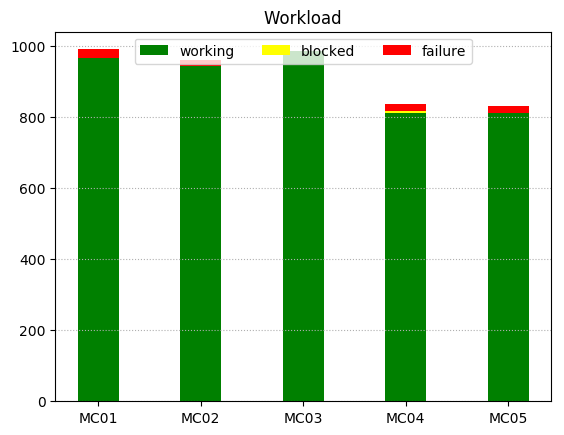

In [29]:
loadbars(wus)

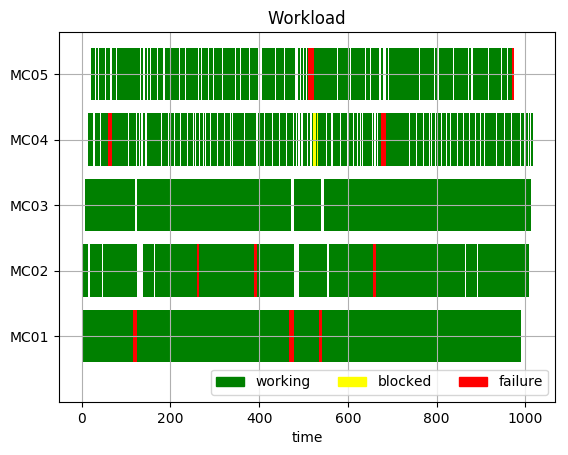

In [30]:
loadtime(wus)

HTML{String}("<h3>Product flow graph</h3>")

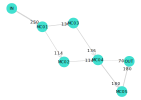

In [31]:
srand(2017) # for reproducibility
(G, nodes, weights) = flowgraph(finished)
display(HTML("<h3>Product flow graph</h3>"))
display(gplot(G, nodelabel=nodes, edgelabel=weights, edgelinewidth=weights))

Another order of magnitude, 2500 products:

In [32]:
plan1 = Planned(123,  700, 123000, "Order 1", "Order 1 description", "ORD01")
plan2 = Planned(456, 1800, 456000, "Order 2", "Order 2 description", "ORD02")
mps = create_mps([plan1, plan2], d);
srand(2345)  # seed random number generator for reproducibility
sim = DES()
wus = readWorkunits(wufile, sim)
finished = Products()
sleep(1) # wait for sync

start_scheduling(sim, wus, mps, finished)
simulate(sim, 10000)
println("$(length(finished)) products were produced")


res = leadtimetable(finished)
res[:starttime] = round.(res[:starttime], 2)
res[:endtime] = round.(res[:endtime], 2)
ml = round(mean(res[:leadtime][end-1000:end]), 2)
println("mean leadtime for last 1000 products: $ml")

Simulation ends after 2330 ms - next event at:10000.0 ≥ stime after 66620 events
2500 products were produced
mean leadtime for last 1000 products: 70.54
